In [1]:
import mlflow

import torch
import torch.nn as nn
from torchinfo import summary
from torchmetrics import Accuracy
from torch.utils.data import Dataset, DataLoader
from VAE.model import VAE
import matplotlib.pyplot as p
from torch.autograd import Variable 
import matplotlib.pyplot as plt
from VAE.data import Ego4d, DEVICE, BATCH_SIZE, transform1, transform2

device cuda is ready


In [2]:
print('transform initializate sucsess')
train_dataset = Ego4d(img_dir='/home/qwest/data_for_ml/1_25/',
                           transform1=transform1,
                           transform2=transform2)
print("train_dataset init")
train_loader = DataLoader(dataset=train_dataset,
                           batch_size=BATCH_SIZE,
                           shuffle=True,
                           num_workers=6)
print("train_loader init")

transform initializate sucsess
train_dataset init
train_loader init


In [3]:
len(train_loader)

9746

In [4]:
loss_fn = nn.CrossEntropyLoss()

In [5]:
mlflow.set_tracking_uri("http://localhost:8080")

In [6]:
mlflow.set_experiment("/VAE-pytorch")

<Experiment: artifact_location='file:///home/qwest/project/PycharmProjects/Reinforsment_Learning/mlruns/693143429450822504', creation_time=1729715917359, experiment_id='693143429450822504', last_update_time=1729715917359, lifecycle_stage='active', name='/VAE-pytorch', tags={}>

In [7]:
from torch import nn, optim 

In [8]:
lr = 0.001
epochs = 70
latent_dim = 128

#model = VAE(latent_dim, batch_size=BATCH_SIZE).to(DEVICE)
#model = torch.load(f"/home/qwest/project/PycharmProjects/Reinforsment_Learning/VAE/weights/loss_1393/VAE_6.pt", weights_only=False)
#optimizer = optim.Adam(model.parameters(), lr=lr)

In [41]:
model = VAE(latent_dim, batch_size=BATCH_SIZE).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=lr)

checkpoint = torch.load('/home/qwest/project/PycharmProjects/Reinforsment_Learning/test_W/VAE_checkpoint_12810.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

/tmp/ipykernel_71627/3935702495.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('VAE/weights/VAE_checkpoint10.pt')


In [42]:
loss

tensor(0.5187, device='cuda:0', requires_grad=True)

In [9]:
def train(epoch):
    #for epoch in range(1, epochs+1):
    x = next(iter(train_loader))
    model.train()
    print(f'Epoch {epoch} start')
    eval_loss = 0
    for _, data in enumerate(train_loader):
            data = data.to(DEVICE)
            optimizer.zero_grad()
            
            recon_batch, mu, logvar = model(data)
            loss = model.loss_function(recon_batch, data, mu, logvar)
            eval_loss += loss
            loss.backward()
            optimizer.step()

    torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss':loss,
                'epoch':epoch,
                'full_model':model
                },
                f'test_W/VAE_checkpoint_{latent_dim}{epoch}.pt')
    
    model.eval()
    mlflow.log_metric("total_loss", f"{loss:2f}", step=epoch)
    print(f"Avg loss: {loss:2f} \n")
    recon_img, _, _ = model(x[:1].to(DEVICE))
    img = recon_img.view(3, 64, 64).detach().cpu().numpy().transpose(1, 2, 0)
    f = p.imshow(img)
    p.show()
    #recon_img, _, _ = model(x[:1].to(DEVICE))
    #img = recon_img.view(3, 64, 64).detach().cpu().numpy().transpose(1, 2, 0)

        #torch.save(train_loader, f'train_loadet_{epochs}.pt')



In [10]:
#plt.imshow(model(torch.tensor(input)[:1].to(DEVICE))[0][0].view(3, 64, 64).detach().cpu().numpy().transpose(1, 2, 0))

In [12]:
# signature = mlflow.models.infer_signature(
#     input,
#     model(torch.tensor(input)[:1].to(DEVICE))[0][0].view(3, 64, 64).detach().cpu().numpy().transpose(1, 2, 0),
# )

In [223]:
# def evaluation(dataloader, model, loss_fn, epochs):
#     num_batches = len(dataloader)
#     model.eval()
#     eval_loss = 0.0
#     with torch.no_grad():
#         for X in dataloader:
#             Y = model(torch.tensor(X)[:1].to(DEVICE))[0][0].view(3, 64, 64).detach().cpu().numpy()
#             eval_loss += loss_fn(torch.tensor(Y), torch.tensor(X[0])).item()
#     eval_loss /= num_batches
#     mlflow.log_metric("eval_loss", f"{eval_loss:2f}", step=epochs)
#     print(f"Avg loss: {eval_loss:2f} \n")

Epoch 1 start
Avg loss: 0.541533 



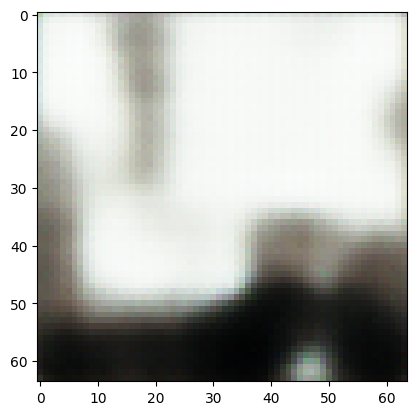

Epoch 2 start
Avg loss: 0.521457 



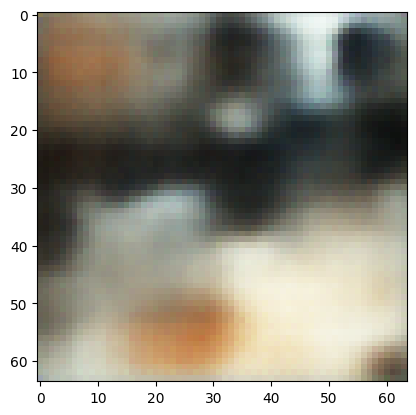

Epoch 3 start
Avg loss: 0.521588 



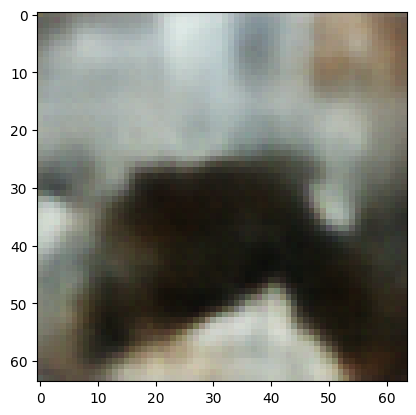

Epoch 4 start
Avg loss: 0.524253 



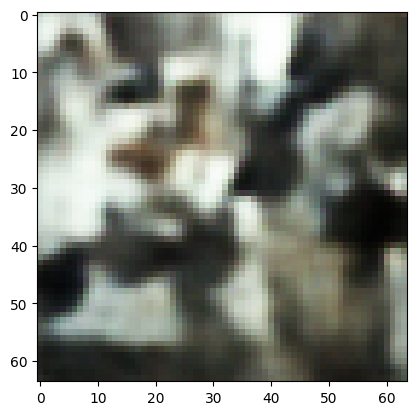

Epoch 5 start
Avg loss: 0.524292 



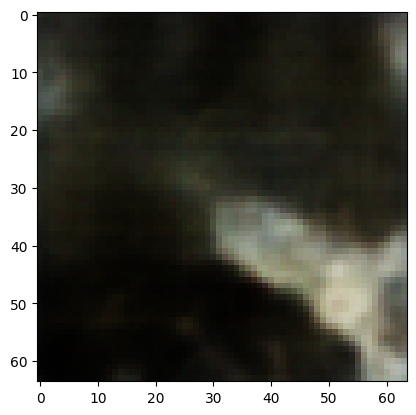

Epoch 6 start
Avg loss: 0.532482 



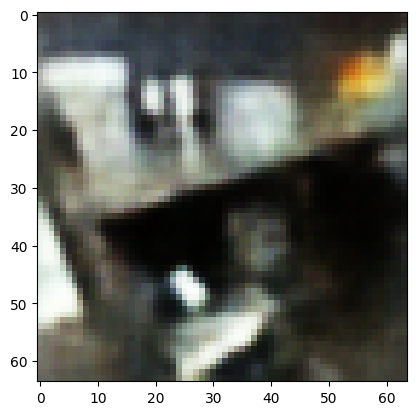

Epoch 7 start
Avg loss: 0.525668 



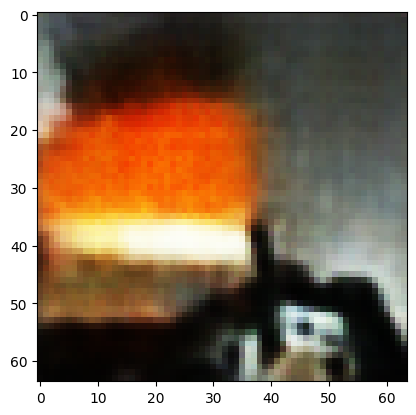

Epoch 8 start
Avg loss: 0.486546 



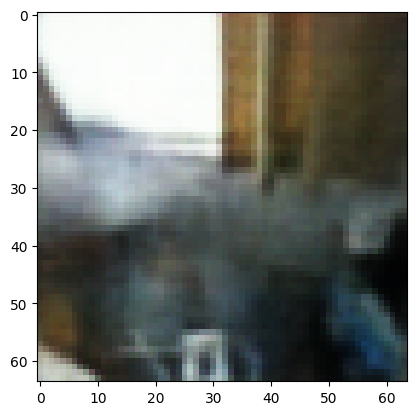

Epoch 9 start
Avg loss: 0.516889 



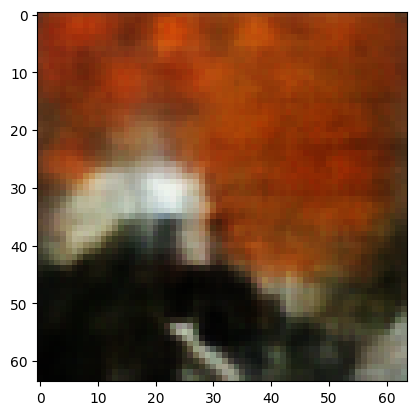

Epoch 10 start
Avg loss: 0.520449 



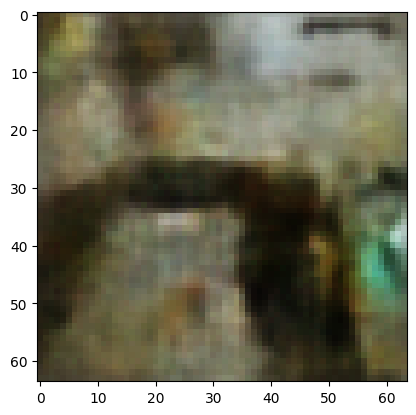

2024/10/31 23:21:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/31 23:21:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run auspicious-bug-969 at: http://localhost:8080/#/experiments/693143429450822504/runs/2afe0e4a7be74fe58ccfc62d7f8268df.
2024/10/31 23:21:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/693143429450822504.


In [10]:
with mlflow.start_run() as run:
    params = {
        "epochs": epochs,
        "learning_rate": lr,
        "batch_size": BATCH_SIZE,
        #"loss_function": loss_fn.__class__.__name__,
        "metric_function": "BCE",
        "optimizer": "Adam",
    }
    # Log training parameters.
    mlflow.log_params(params)

    # Log model summary.|
    with open("model_summary.txt", "w") as f:
        f.write(str(summary(model)))
    mlflow.log_artifact("model_summary.txt")

    for t in range(1, epochs+1):
        train(t)
        #torch.save(model, f'VAE{t}.pt')
        #train(train_dataloader, model, loss_fn, metric_fn, optimizer, epoch=t)
        #evaluation(train_loader, model, loss_fn, epochs=t)

    # Save the trained model to MLflow.
    mlflow.pytorch.log_model(model, "model")#, signature=signature)
    

In [110]:
model = VAE(32, batch_size=BATCH_SIZE).to(DEVICE)

In [11]:
# checkpoint = torch.load('/home/qwest/project/PycharmProjects/Reinforsment_Learning/test_W/VAE_checkpoint_1283.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']
model.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (8): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(512, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4)

In [102]:
print('transform initializate sucsess')
train_dataset = Ego4d(img_dir='/home/qwest/data_for_ml/ROBO/',
                           transform1=transform1,
                           transform2=transform2)
print("train_dataset init")
train_loader = DataLoader(dataset=train_dataset,
                           batch_size=BATCH_SIZE,
                           shuffle=True,
                           num_workers=6)
print("train_loader init")

transform initializate sucsess
train_dataset init
train_loader init


torch.Size([32, 3, 64, 64])


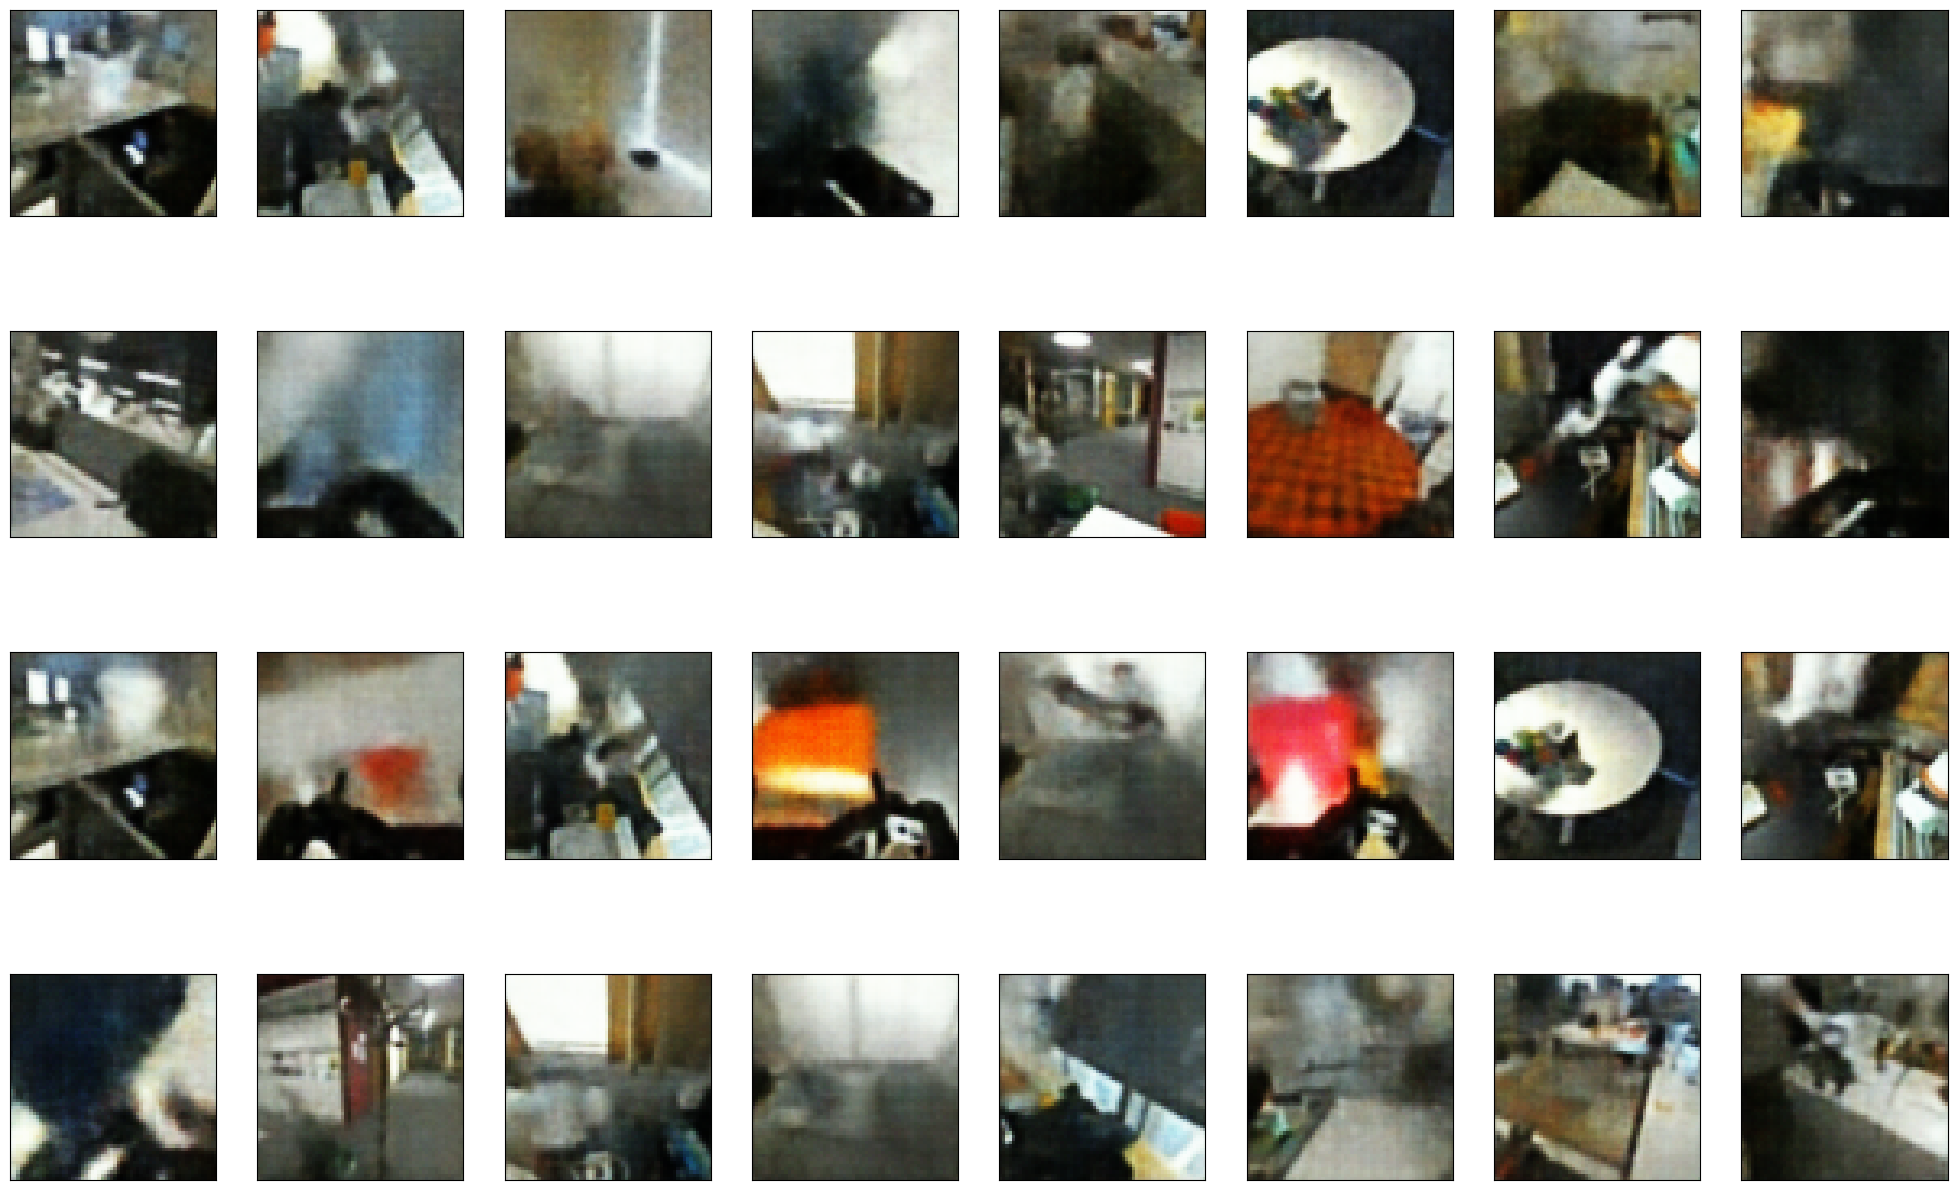

In [12]:
x = next(iter(train_loader))
print(x.size())
reconstructed, mu, _ = model(x.to(DEVICE))
reconstructed = reconstructed.view(-1, 3, 64, 64).detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(reconstructed):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow((img))

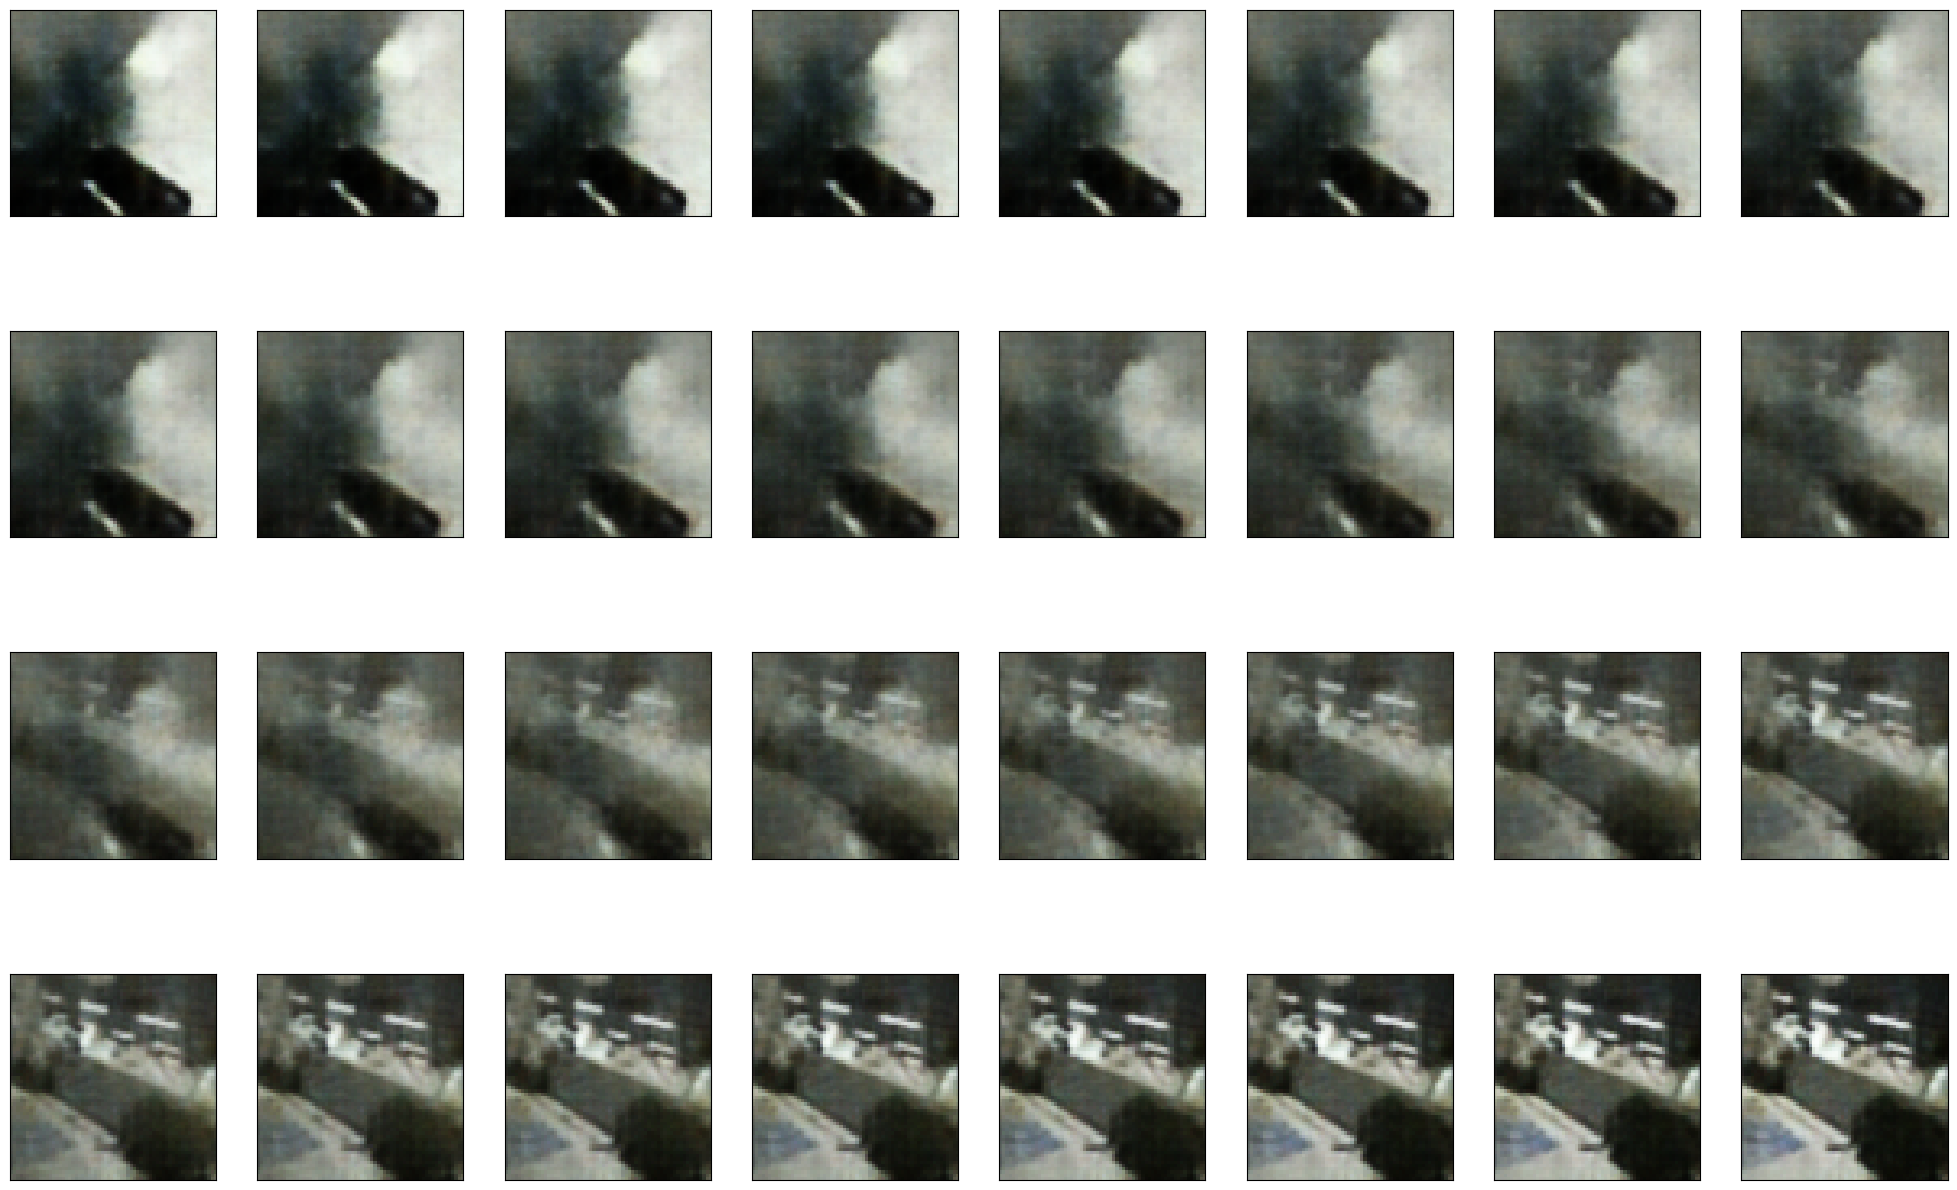

In [13]:
first_dog_idx = 3
second_dog_idx = 8

dz = (mu[second_dog_idx] - mu[first_dog_idx]) / 31
walk = Variable(torch.randn(32, latent_dim, 4, 4)).to(DEVICE)
walk[0] = mu[first_dog_idx]

for i in range(1, 32):
    walk[i] = walk[i-1] + dz
walk = model.decoder(walk).detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(walk):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow((img))

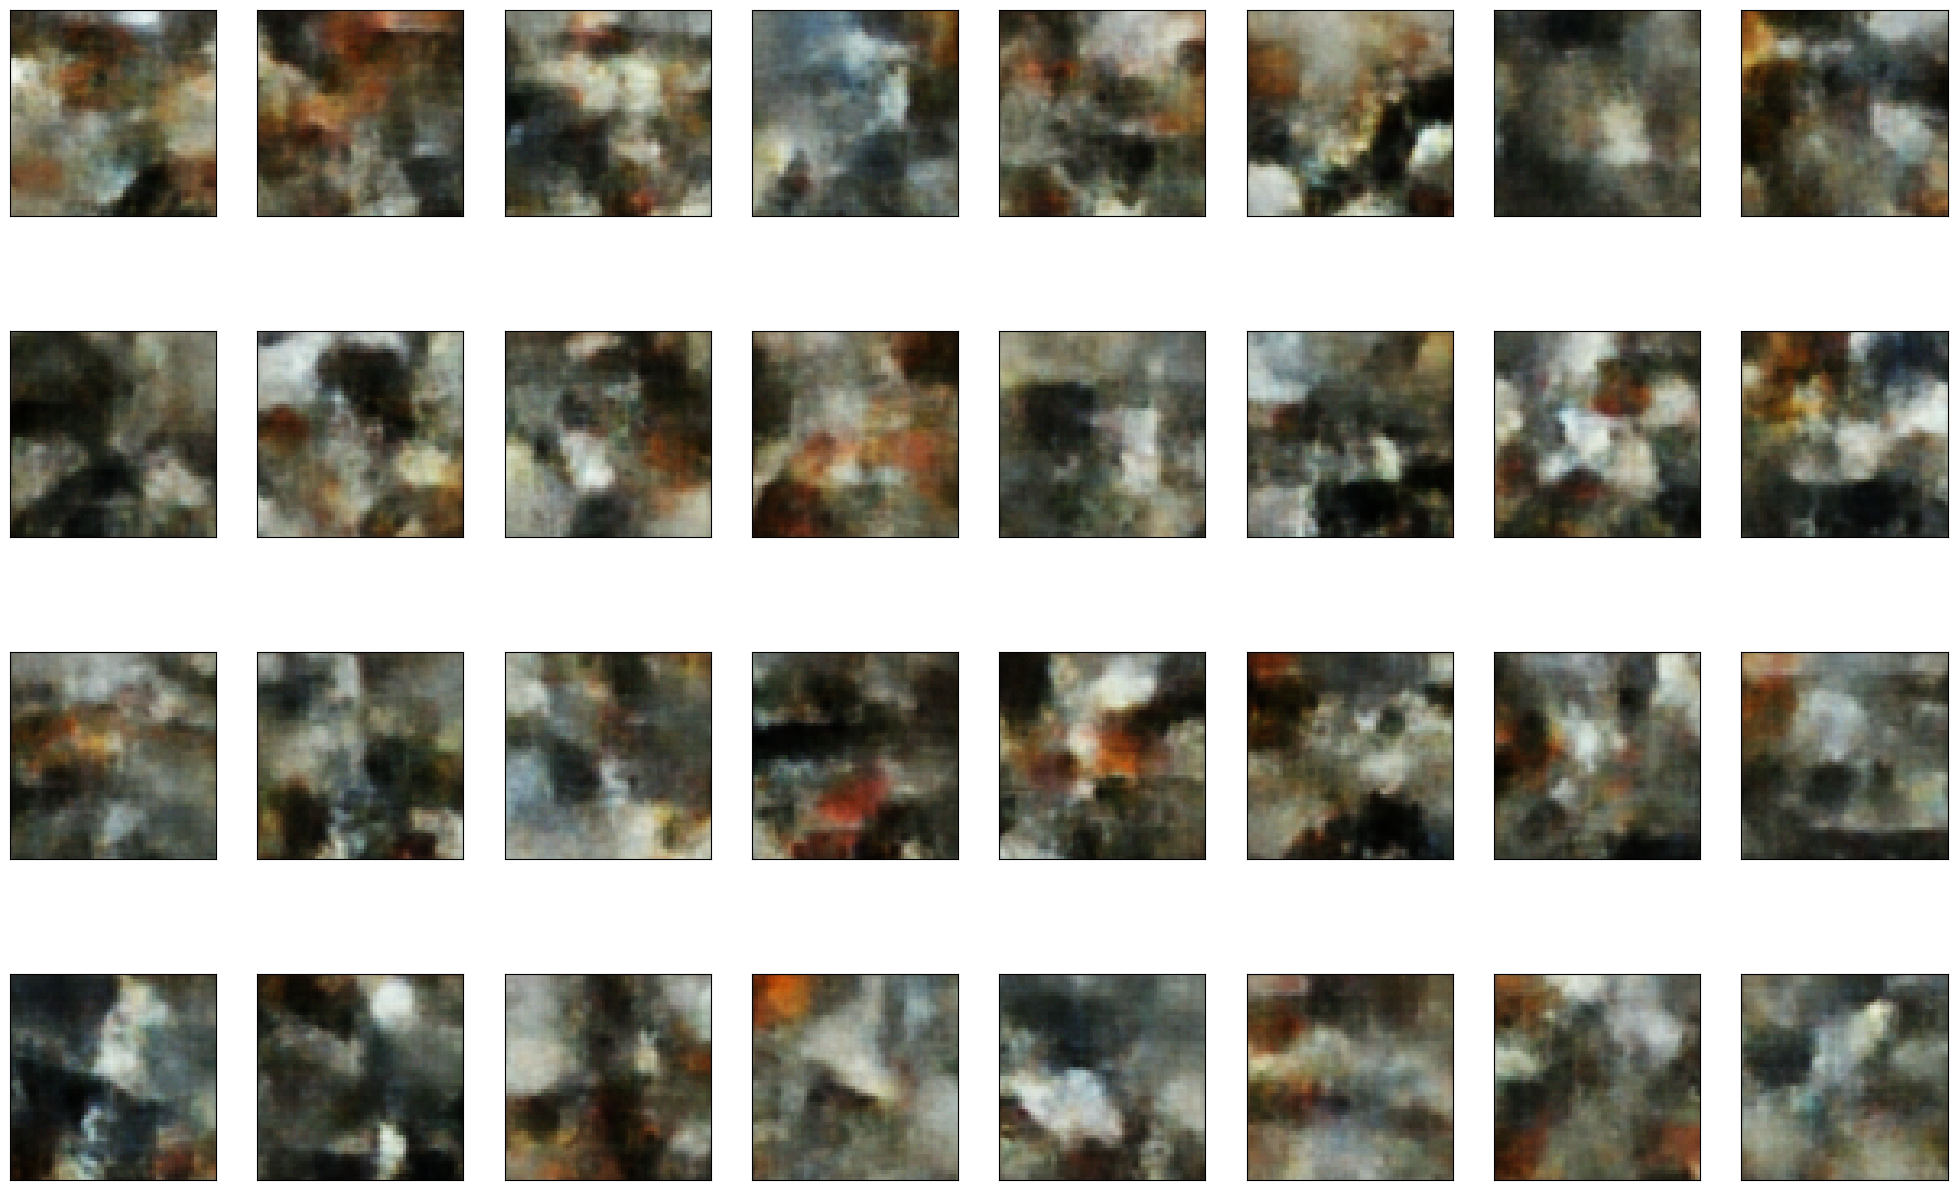

In [14]:
samples = Variable(torch.randn(32, latent_dim, 4, 4)).to(DEVICE)
samples = model.decoder(samples).detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(samples):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow((img))

In [ ]:
with torch.no_grad():
    